<a href="https://colab.research.google.com/github/npl0204/Brain-Tumor-Detection/blob/main/Brain_Tumor_Detection_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. **Loading Packages and Libraries**

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-eligdwpd
  Running command git clone --filter=blob:none --quiet https://github.com/qubvel/segmentation_models /tmp/pip-req-build-eligdwpd
  Resolved https://github.com/qubvel/segmentation_models to commit e951c6747f75fa9e7240816d1c79dd2e66813123
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done


In [ ]:
import pandas as pd
import os
from os import environ
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import cv2
import tensorflow as tf

from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import io
import PIL.Image
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
from IPython.display import display, Image
from tkinter import *
from PIL import ImageTk, Image

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import applications
from tensorflow import keras
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
import efficientnet.tfkeras as efn

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. **Create Datasets**

## **Load Datasets**

In [ ]:
# Creating dataframe by iterating through filepaths
tumor_dir = r'/content/drive/MyDrive/DSCI 471-Project/archive/yes'
healthy_dir = r'/content/drive/MyDrive/DSCI 471-Project/archive/no'

filepaths = []
labels= []
dict_list = [tumor_dir, healthy_dir]
for i, j in enumerate(dict_list): 
    flist=os.listdir(j)
    for f in flist:
        fpath=os.path.join(j,f)
        filepaths.append(fpath)
        if i==0:
          labels.append('cancer')
        else:
          labels.append('healthy') 
    
Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
tumor_data = pd.concat([Fseries,Lseries], axis=1)
tumor_df = pd.DataFrame(tumor_data)
print(tumor_df.head())
print(tumor_df["labels"].value_counts())

                                           filepaths  labels
0  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
1  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
2  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
3  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
4  /content/drive/MyDrive/DSCI 471-Project/archiv...  cancer
cancer     155
healthy     98
Name: labels, dtype: int64


In [ ]:
tumor_df.shape

(253, 2)

## **Split Datasets for Training**

In [ ]:
train_images, test_images = train_test_split(tumor_df, test_size=0.3, random_state=42)
train_images, val_set = train_test_split(train_images, test_size=0.2, random_state=42)

In [ ]:
print(test_images.shape)
print(val_set.shape)
print(train_images.shape)

(76, 2)
(36, 2)
(141, 2)


## **Display Data**

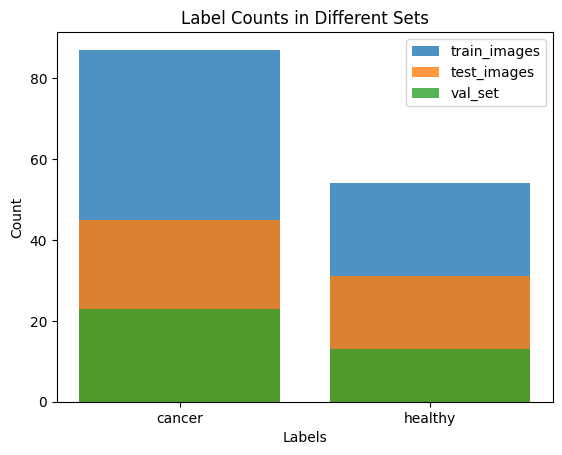

In [ ]:
# Count the occurrences of each label for each table
train_label_counts = train_images['labels'].value_counts()
test_label_counts = test_images['labels'].value_counts()
val_label_counts = val_set['labels'].value_counts()

# Plot the bar charts
plt.bar(train_label_counts.index, train_label_counts.values, alpha=0.8, label='train_images')
plt.bar(test_label_counts.index, test_label_counts.values, alpha=0.8, label='test_images')
plt.bar(val_label_counts.index, val_label_counts.values, alpha=0.8, label='val_set')

plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Label Counts in Different Sets')

plt.legend()
plt.show()

## **Data/Image Augmentation**

Data/image augmentation is a technique used to artificially increase the size of the training dataset and improve the generalization ability of the model. It helps to address the problem of overfitting and makes the model more robust to variations in the input data.

In the provided code, the `ImageDataGenerator` class from Keras is used to perform data/image augmentation. Here's an explanation of the augmentation techniques we used:

1. Rotation Range: The images can be randomly rotated within a specified range (in degrees). This helps the model learn to recognize objects from different angles.
2. Width and Height Shift Range: The images can be randomly shifted horizontally and vertically by a fraction of the total width and height, respectively. This introduces variations in the position of objects in the images.
3. Rescale: The pixel values of the images are rescaled by dividing them by 255. This brings the pixel values into the range of [0, 1], which is typically beneficial for training deep learning models.
4. Shear Range: The images can be randomly sheared within a specified range. Shearing transforms the shape of objects in the images, helping the model generalize to different object shapes.
5. Brightness Range: The brightness of the images can be randomly adjusted within a specified range. This introduces variations in the lighting conditions, making the model more robust to changes in brightness.
6. Horizontal and Vertical Flip: The images can be randomly flipped horizontally and vertically. Flipping helps the model learn invariant representations and improves its ability to recognize objects regardless of their orientation.

The `train_generator`, `test_generator`, and `validation_generator` are created using the `flow_from_dataframe` method, which generates batches of augmented images from the provided dataframes. These generators will provide augmented images to the model during training, testing, and validation, respectively.

By applying data/image augmentation, the model can learn from a more diverse set of training examples, leading to better generalization and improved performance on unseen data.

In [ ]:
image_size = 224
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    test_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

validation_generator = test_datagen.flow_from_dataframe(
    val_set,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

Found 141 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [ ]:
print("Information about Training Dataset:")
print(train_generator.class_indices)
print(train_generator.image_shape, end = '\n\n')
 
print("Information about Validation Dataset:")
print(validation_generator.class_indices)
print(validation_generator.image_shape, end = '\n\n')
 
print("Information about Testing Dataset:")
print(test_generator.class_indices)
print(test_generator.image_shape)

Information about Training Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 3)

Information about Validation Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 3)

Information about Testing Dataset:
{'cancer': 0, 'healthy': 1}
(224, 224, 3)


In [ ]:
x_test, y_test = [], []

# Iterate over the test generator to extract the images and labels
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    x_test.append(images)
    y_test.append(labels)

# Concatenate the image and label arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

# Verify the shapes of x_test and y_test
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (76, 224, 224, 3)
y_test shape: (76,)


## **Data Presentation**

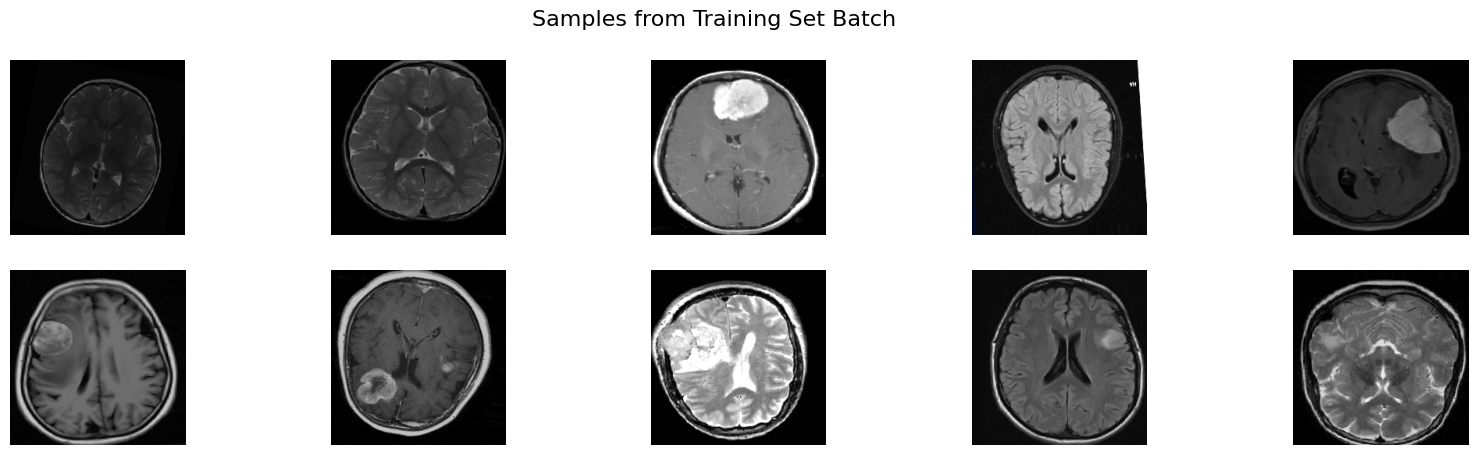

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 5))
fig.suptitle("Samples from Training Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), train_generator[0][0][:11]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

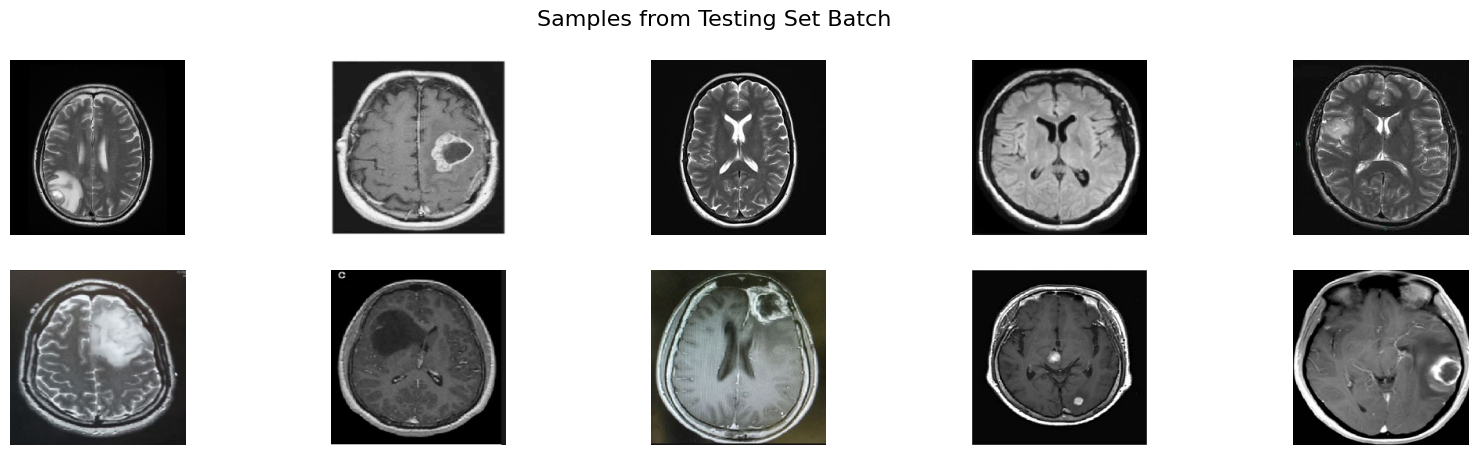

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 5))
fig.suptitle("Samples from Testing Set Batch", fontsize = 16, fontdict = dict(weight = 'bold'))
for curr_axis, curr_image in zip(axes.flatten(), test_generator[0][0][:11]):
    curr_axis.imshow(tf.squeeze(curr_image), cmap = 'gray')
    curr_axis.axis(False)

# 3. **Deep Learning**


In [ ]:
acc_scores = []
f1_scores = []
model_names = []

### **Baseline Model with MLP**

In [ ]:
mlp_model = keras.Sequential([
    keras.layers.Flatten(input_shape=[image_size, image_size, 3]),
    keras.layers.Dense(1024,activation="relu"),
    keras.layers.Dropout(rate=0.2),    
    keras.layers.Dense(512,activation="relu"),

    keras.layers.Flatten(),
    keras.layers.Dropout(rate=0.5),
    keras.layers.Dense(256,activation="relu"),
    keras.layers.Dense(1,activation="sigmoid")
])

In [ ]:
LEARNING_RATE = 0.001
EPOCHS = 200

mlp_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  metrics=["accuracy"])

Here, we will use **Early Stopping** in the training process of a model to prevent overfitting and improve generalization by monitoring the model's performance on a validation set during training. It allows the training process to stop early if the model's performance on the validation set does not improve or starts to deteriorate.

Our `EarlyStopping` callback is created with the following arguments:
- `monitor='val_accuracy'`: The training process will track the validation accuracy and stop if it does not improve.
- `mode='max'`: We want to maximize the validation accuracy, we set it to `'max'`.
- `patience=40`: This determines the number of epochs with no improvement after which training will be stopped.

During training, the model's performance on the training and validation data is recorded in the `history` object, which can be used to analyze and visualize the training progress, including metrics like accuracy and loss over epochs.

In [ ]:
es = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=40
)

history = mlp_model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        callbacks=[es])

Epoch 1/200
5/5 [==============================] - 5s 479ms/step - loss: 17.9609 - accuracy: 0.4823 - val_loss: 11.0540 - val_accuracy: 0.6389
Epoch 2/200
5/5 [==============================] - 3s 574ms/step - loss: 14.8481 - accuracy: 0.4823 - val_loss: 12.4898 - val_accuracy: 0.6389
Epoch 3/200
5/5 [==============================] - 4s 723ms/step - loss: 16.4214 - accuracy: 0.5106 - val_loss: 8.9166 - val_accuracy: 0.6389
Epoch 4/200
5/5 [==============================] - 3s 672ms/step - loss: 14.8618 - accuracy: 0.5674 - val_loss: 7.8959 - val_accuracy: 0.4722
Epoch 5/200
5/5 [==============================] - 2s 510ms/step - loss: 14.3632 - accuracy: 0.5390 - val_loss: 1.0085 - val_accuracy: 0.8056
Epoch 6/200
5/5 [==============================] - 2s 444ms/step - loss: 10.8014 - accuracy: 0.4681 - val_loss: 5.9825 - val_accuracy: 0.6389
Epoch 7/200
5/5 [==============================] - 2s 454ms/step - loss: 9.6663 - accuracy: 0.5532 - val_loss: 10.8030 - val_accuracy: 0.3611
Epoc

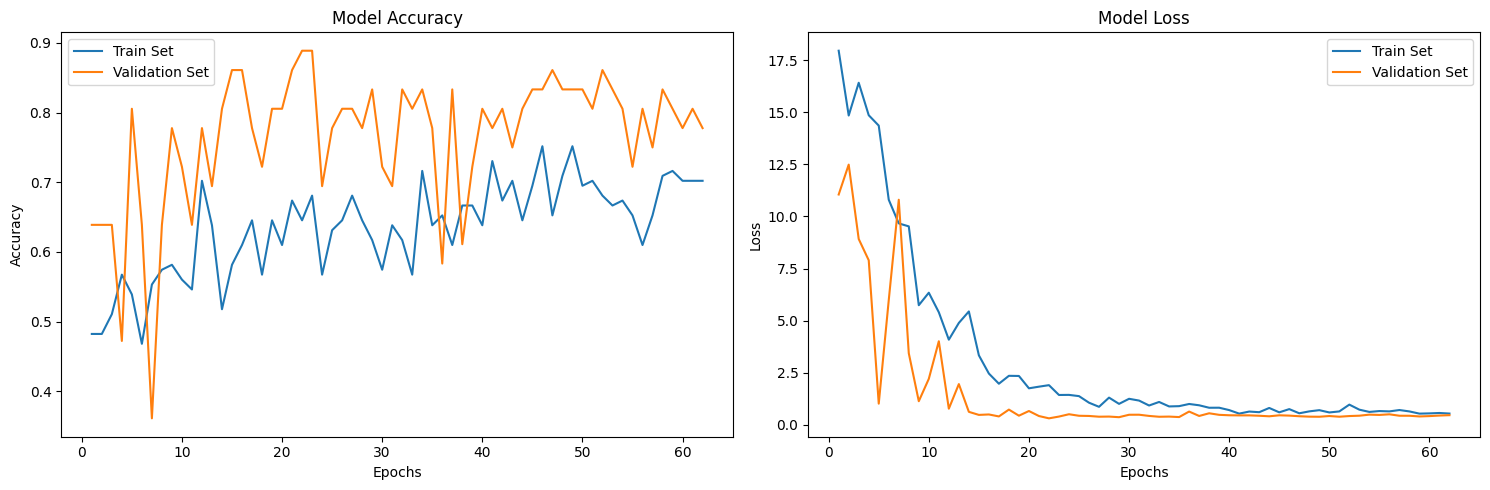

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Validation set accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation set loss
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')  # Add validation set accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')  # Add validation set loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = mlp_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 0s 9ms/step
Test Accuracy = 0.75
F1 Score = 0.60
[[43  2]
 [17 14]]


In [ ]:
model_names.append("Baseline Model with MLP")
f1_scores.append(f1)
acc_scores.append(accuracy)

### **Add Convolutional Neural Network**

In [ ]:
cnn_model = keras.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=(5,5), activation="relu", padding='same', input_shape=[image_size, image_size, 3]),
    keras.layers.MaxPool2D(),
    
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding='same'),
    keras.layers.MaxPool2D(),
    
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding='same'),
    keras.layers.MaxPool2D(),
    
    keras.layers.Flatten(),
    keras.layers.Dropout(.5),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 128)     

In [ ]:
cnn_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  metrics=["accuracy"])

In [ ]:
history = cnn_model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        callbacks=[es])

Epoch 1/200
5/5 [==============================] - 6s 455ms/step - loss: 1.9054 - accuracy: 0.5461 - val_loss: 0.6173 - val_accuracy: 0.7778
Epoch 2/200
5/5 [==============================] - 2s 468ms/step - loss: 0.6184 - accuracy: 0.7376 - val_loss: 0.4953 - val_accuracy: 0.7222
Epoch 3/200
5/5 [==============================] - 2s 531ms/step - loss: 0.5490 - accuracy: 0.7660 - val_loss: 0.4251 - val_accuracy: 0.8333
Epoch 4/200
5/5 [==============================] - 2s 426ms/step - loss: 0.5632 - accuracy: 0.7234 - val_loss: 0.3942 - val_accuracy: 0.8056
Epoch 5/200
5/5 [==============================] - 2s 512ms/step - loss: 0.5247 - accuracy: 0.7730 - val_loss: 0.4118 - val_accuracy: 0.8056
Epoch 6/200
5/5 [==============================] - 2s 443ms/step - loss: 0.5318 - accuracy: 0.7589 - val_loss: 0.4762 - val_accuracy: 0.7778
Epoch 7/200
5/5 [==============================] - 2s 448ms/step - loss: 0.4944 - accuracy: 0.7589 - val_loss: 0.4335 - val_accuracy: 0.7778
Epoch 8/200
5

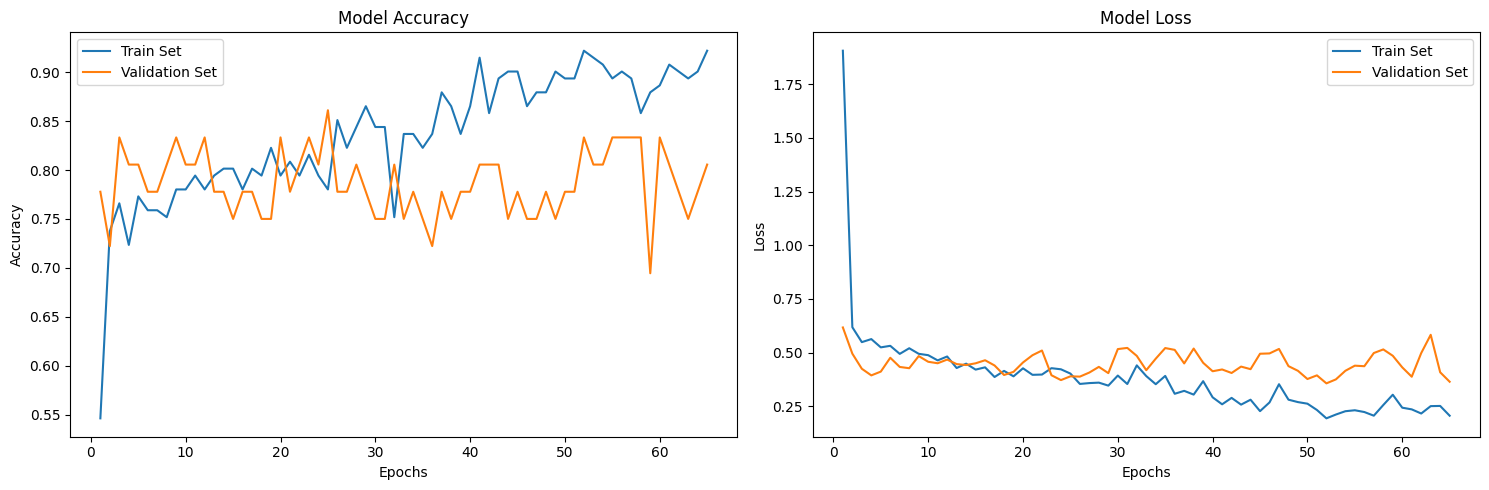

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Validation set accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation set loss
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')  # Add validation set accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')  # Add validation set loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = cnn_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 0s 164ms/step
Test Accuracy = 0.84
F1 Score = 0.80
[[40  5]
 [ 7 24]]


In [ ]:
model_names.append("Adding CNN")
f1_scores.append(f1)
acc_scores.append(accuracy)

### **Add VGG16**

In [ ]:
base_model = applications.vgg16.VGG16(include_top=False, weights='imagenet', input_shape = (image_size, image_size, 3))

In [ ]:
vgg_model = keras.Sequential([
    base_model, 
    keras.layers.MaxPooling2D(pool_size=(2,2)),

    keras.layers.Flatten(),
    keras.layers.Dropout(.5),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])
vgg_model.layers[0].trainable = False

vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 3, 3, 512)        0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 4608)              0         
                                                                 
 dropout_3 (Dropout)         (None, 4608)              0         
                                                                 
 dense_6 (Dense)             (None, 256)               1179904   
                                                                 
 dense_7 (Dense)             (None, 1)                 257       
                                                      

In [ ]:
vgg_model.compile(loss="binary_crossentropy",
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                  metrics=["accuracy"])

In [ ]:
history = vgg_model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        callbacks=[es])

Epoch 1/200
5/5 [==============================] - 11s 1s/step - loss: 1.4730 - accuracy: 0.5177 - val_loss: 0.6541 - val_accuracy: 0.5833
Epoch 2/200
5/5 [==============================] - 3s 493ms/step - loss: 0.6970 - accuracy: 0.6170 - val_loss: 0.5283 - val_accuracy: 0.7222
Epoch 3/200
5/5 [==============================] - 3s 500ms/step - loss: 0.5586 - accuracy: 0.7234 - val_loss: 0.4294 - val_accuracy: 0.8056
Epoch 4/200
5/5 [==============================] - 2s 475ms/step - loss: 0.4926 - accuracy: 0.7943 - val_loss: 0.3861 - val_accuracy: 0.8611
Epoch 5/200
5/5 [==============================] - 2s 471ms/step - loss: 0.4165 - accuracy: 0.8156 - val_loss: 0.3720 - val_accuracy: 0.8333
Epoch 6/200
5/5 [==============================] - 2s 563ms/step - loss: 0.3700 - accuracy: 0.8440 - val_loss: 0.3697 - val_accuracy: 0.8611
Epoch 7/200
5/5 [==============================] - 3s 586ms/step - loss: 0.3501 - accuracy: 0.8652 - val_loss: 0.3486 - val_accuracy: 0.8611
Epoch 8/200
5/5

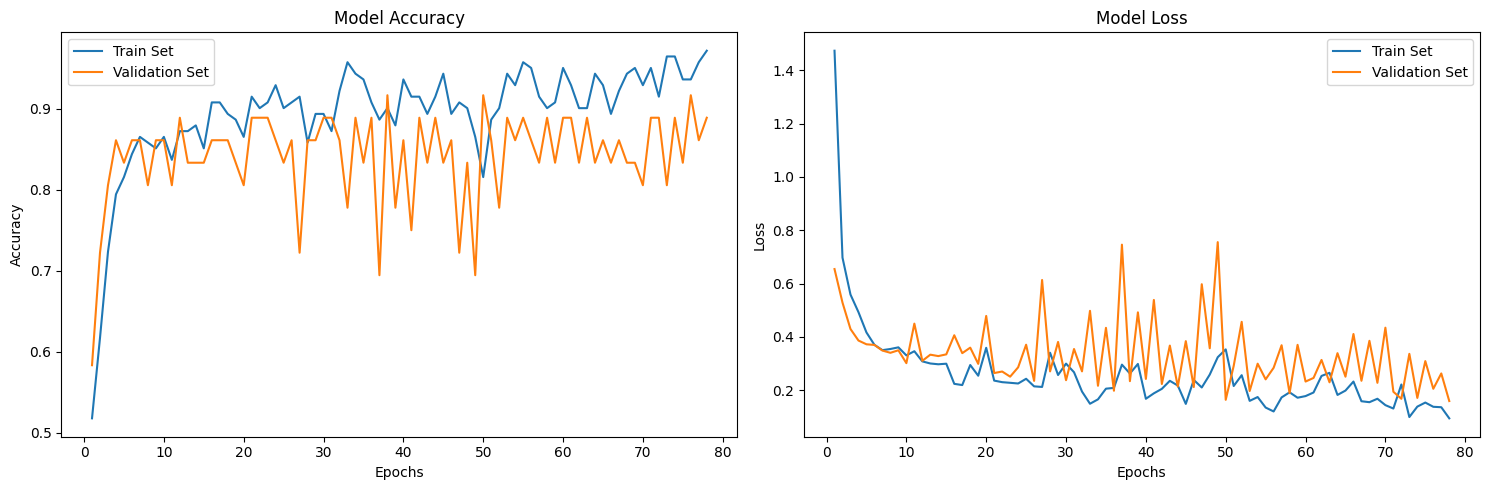

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Validation set accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation set loss
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')  # Add validation set accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')  # Add validation set loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = vgg_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 2s 1s/step
Test Accuracy = 0.84
F1 Score = 0.79
[[42  3]
 [ 9 22]]


In [ ]:
model_names.append("Adding VGG")
f1_scores.append(f1)
acc_scores.append(accuracy)

### **Add EfficientNetB2**

We chose to use **Efficient Net B2** for our model because it offers a powerful combination of efficiency and accuracy in image recognition tasks. EfficientNetB2 is a specific variant of the EfficientNet architecture that strikes a good balance between model size and accuracy. It has been optimized to provide excellent performance while being computationally efficient, making it suitable for a wide range of applications.

One of the key advantages of EfficientNetB2 is its ability to achieve high accuracy with relatively fewer parameters compared to other models. This efficiency is achieved through a combination of advanced techniques such as compound scaling, which scales the model's depth, width, and resolution in a balanced manner. The EfficientNetB2 architecture has been carefully designed and fine-tuned to achieve a good trade-off between model size and accuracy.

Additionally, EfficientNetB2 benefits from the pretraining on large-scale image datasets, such as ImageNet, which helps the model learn rich and discriminative features that can be leveraged for various image recognition tasks.

By choosing EfficientNetB2, we expected to leverage its efficient architecture and pretrained weights to achieve high accuracy in image classification while keeping the computational requirements manageable. The EfficientNetB2 model provides a solid foundation for extracting meaningful features from images and making accurate predictions.

EfficientNet is a family of convolutional neural network (CNN) models that are designed to achieve improved accuracy and efficiency in image training tasks. It introduces a novel method for scaling CNNs in a structured and principled manner, called compound model scaling.

Traditionally, CNNs were scaled up by increasing their depth, width, or input image resolution. However, these approaches often required manual tuning and did not always result in optimal performance. EfficientNet addresses these limitations by uniformly scaling all dimensions of the network, including width, depth, and image resolution, using a fixed set of scaling coefficients.

The scaling process involves performing a grid search to determine the appropriate scaling coefficients for each dimension under a fixed resource constraint. This ensures that all dimensions are balanced against the available resources, leading to improved overall performance. By applying these coefficients, the baseline network is scaled up to the desired target model size or computational budget.

EfficientNet also introduces a new baseline network architecture, developed through neural architecture search using the AutoML MNAS framework. This baseline network, called EfficientNet-B0, is optimized for both accuracy and efficiency. It utilizes mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but with slightly larger size.

The performance of EfficientNet models has been evaluated on ImageNet, a popular image classification dataset. They have achieved higher accuracy and better efficiency compared to existing CNNs, significantly reducing parameter size and floating-point operations (FLOPS) by an order of magnitude. For example, EfficientNet-B7 achieved state-of-the-art accuracy while being 8.4x smaller and 6.1x faster on CPU inference than previous approaches.

EfficientNets also demonstrated good transfer learning capabilities, achieving state-of-the-art accuracy on multiple transfer learning datasets while using significantly fewer parameters.

The combination of improved accuracy and efficiency makes EfficientNet models a valuable tool for various computer vision tasks. The models have been open-sourced to benefit the machine learning community, and their source code and training scripts are available for use.

https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

In [ ]:
base_model = efn.EfficientNetB2(include_top=False, weights='imagenet', input_shape = (image_size, image_size, 3))

In [ ]:
efn_model = keras.Sequential([
    base_model, 
    keras.layers.GlobalMaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dropout(.5),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])
# efn_model.layers[0].trainable = False

efn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 7, 7, 1408)       7768562   
 )                                                               
                                                                 
 global_max_pooling2d (Globa  (None, 1408)             0         
 lMaxPooling2D)                                                  
                                                                 
 flatten_4 (Flatten)         (None, 1408)              0         
                                                                 
 dropout_4 (Dropout)         (None, 1408)              0         
                                                                 
 dense_8 (Dense)             (None, 256)               360704    
                                                                 
 dense_9 (Dense)             (None, 1)                

In [ ]:
efn_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     metrics=["accuracy"])

In [ ]:
history = efn_model.fit(train_generator,
                        epochs=EPOCHS,
                        validation_data=validation_generator,
                        callbacks=[es])

Epoch 1/200
5/5 [==============================] - 61s 1s/step - loss: 1.6516 - accuracy: 0.5461 - val_loss: 0.8616 - val_accuracy: 0.6944
Epoch 2/200
5/5 [==============================] - 3s 559ms/step - loss: 0.7706 - accuracy: 0.8227 - val_loss: 2.6391 - val_accuracy: 0.4444
Epoch 3/200
5/5 [==============================] - 3s 447ms/step - loss: 1.1277 - accuracy: 0.7589 - val_loss: 1.0727 - val_accuracy: 0.7500
Epoch 4/200
5/5 [==============================] - 3s 512ms/step - loss: 0.6714 - accuracy: 0.8511 - val_loss: 0.9038 - val_accuracy: 0.7500
Epoch 5/200
5/5 [==============================] - 3s 494ms/step - loss: 0.4496 - accuracy: 0.8723 - val_loss: 0.4036 - val_accuracy: 0.8333
Epoch 6/200
5/5 [==============================] - 3s 529ms/step - loss: 0.4707 - accuracy: 0.9078 - val_loss: 0.8313 - val_accuracy: 0.8333
Epoch 7/200
5/5 [==============================] - 3s 507ms/step - loss: 0.3520 - accuracy: 0.8794 - val_loss: 1.0076 - val_accuracy: 0.8611
Epoch 8/200
5/5

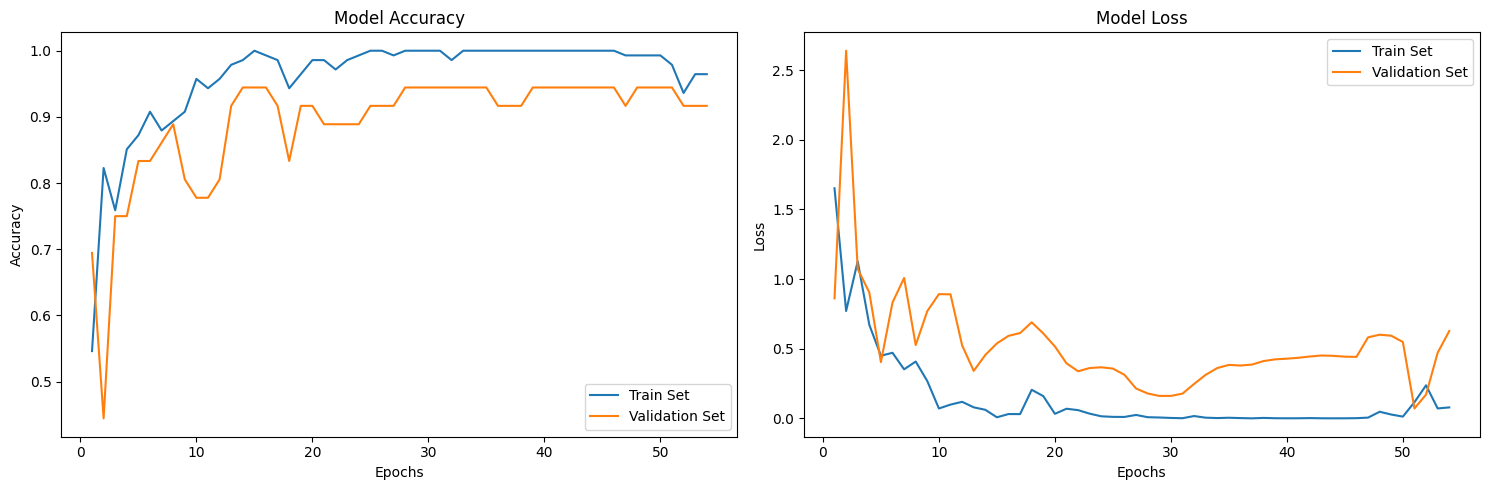

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Validation set accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation set loss
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')  # Add validation set accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')  # Add validation set loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = efn_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 3s 452ms/step
Test Accuracy = 0.89
F1 Score = 0.87
[[42  3]
 [ 5 26]]


In [ ]:
model_names.append("Adding EfficientNetB2")
f1_scores.append(f1)
acc_scores.append(accuracy)

### **Add InceptionV3**

We chose to use **Inception v3** for our model because it has shown excellent performance in image recognition tasks. Inception v3 is a deep convolutional neural network architecture that has been trained on a large dataset (ImageNet) and has achieved high accuracy in image classification.

One important aspect of using Inception v3 is that it expects input images to have a specific size. By default, Inception v3 requires images to be of size 299x299 pixels with three color channels (RGB). This input size is determined by the architecture of the model and is optimized to capture the intricate details and patterns in the images.

Before training with this, we resized the images to the required size of 299x299x3 to ensure compatibility with the Inception v3 model. While the original size of 224x224x3 is commonly used for many other models, as we used in `VGG16` and `EfficientNetB2`, `InceptionV3` benefits from the larger input size of 299x299x3. We expected that this larger size allows the model to capture more fine-grained details in the images and can potentially lead to better accuracy.

Inception v3 is an advanced image recognition model that has achieved more than 78.1% accuracy on the ImageNet dataset. It incorporates various building blocks and techniques to improve its performance. The model is based on the paper titled "Rethinking the Inception Architecture for Computer Vision" by Szegedy et al.

The architecture of Inception v3 consists of symmetric and asymmetric building blocks. These blocks include convolutional layers, average pooling, max pooling, concatenations, dropouts, and fully connected layers. The model utilizes batch normalization extensively, which helps in stabilizing and accelerating the training process. Batch normalization is applied to activation inputs, improving the overall efficiency of the model.

One important aspect of Inception v3 is the use of the softmax function for computing the loss. Softmax is a popular activation function that produces probability distributions over a set of classes. It is commonly used in multi-class classification tasks, including image recognition.

In terms of training, Inception v3 has been successfully trained on different configurations of Cloud TPUs, such as v2-8, v2-128, and v2-512. The accuracy curves obtained during TPU training match those produced by GPU jobs with similar configurations. The model typically achieves its high accuracy after approximately 170 epochs of training.

To implement Inception v3, code samples are provided for illustrative purposes. However, the actual implementation details can be found on GitHub, where the complete working code is available.

Overall, Inception v3 represents the culmination of various research ideas and techniques, resulting in a highly accurate image recognition model. Its architectural design and the use of batch normalization contribute to its efficiency and performance on large-scale datasets like ImageNet.

https://cloud.google.com/tpu/docs/inception-v3-advanced

In [ ]:
image_size = 299
batch_size = 32

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

test_generator = test_datagen.flow_from_dataframe(
    test_images,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

validation_generator = test_datagen.flow_from_dataframe(
    val_set,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='binary',
    seed=42
)

Found 141 validated image filenames belonging to 2 classes.
Found 76 validated image filenames belonging to 2 classes.
Found 36 validated image filenames belonging to 2 classes.


In [ ]:
x_test, y_test = [], []

# Iterate over the test generator to extract the images and labels
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    x_test.append(images)
    y_test.append(labels)

# Concatenate the image and label arrays
x_test = np.concatenate(x_test)
y_test = np.concatenate(y_test)

# Verify the shapes of x_test and y_test
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (76, 299, 299, 3)
y_test shape: (76,)


In [ ]:
base_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (image_size, image_size, 3))

In [ ]:
resnet_model = keras.Sequential([
    base_model, 
    keras.layers.GlobalMaxPooling2D(),

    keras.layers.Flatten(),
    keras.layers.Dropout(.5),
    keras.layers.Dense(units=256, activation="relu"),
    keras.layers.Dense(units=1, activation="sigmoid")
])
resnet_model.layers[0].trainable = False

resnet_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 8, 8, 2048)        21802784  
                                                                 
 global_max_pooling2d_1 (Glo  (None, 2048)             0         
 balMaxPooling2D)                                                
                                                                 
 flatten_5 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_10 (Dense)            (None, 256)               524544    
                                                                 
 dense_11 (Dense)            (None, 1)                 257       
                                                      

In [ ]:
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
                     metrics=["accuracy"])

In [ ]:
history = resnet_model.fit(train_generator,
                           epochs=EPOCHS,
                           validation_data=validation_generator,
                           callbacks=[es])

Epoch 1/200
5/5 [==============================] - 13s 2s/step - loss: 4.5309 - accuracy: 0.5461 - val_loss: 0.4438 - val_accuracy: 0.7500
Epoch 2/200
5/5 [==============================] - 4s 694ms/step - loss: 0.8068 - accuracy: 0.6809 - val_loss: 0.6630 - val_accuracy: 0.6667
Epoch 3/200
5/5 [==============================] - 4s 704ms/step - loss: 0.8284 - accuracy: 0.6879 - val_loss: 0.2830 - val_accuracy: 0.9167
Epoch 4/200
5/5 [==============================] - 4s 693ms/step - loss: 0.7025 - accuracy: 0.7660 - val_loss: 0.3120 - val_accuracy: 0.8333
Epoch 5/200
5/5 [==============================] - 4s 688ms/step - loss: 0.5778 - accuracy: 0.7801 - val_loss: 0.4042 - val_accuracy: 0.8333
Epoch 6/200
5/5 [==============================] - 4s 731ms/step - loss: 0.3804 - accuracy: 0.8369 - val_loss: 0.2505 - val_accuracy: 0.9167
Epoch 7/200
5/5 [==============================] - 4s 700ms/step - loss: 0.4664 - accuracy: 0.8298 - val_loss: 0.2926 - val_accuracy: 0.8611
Epoch 8/200
5/5

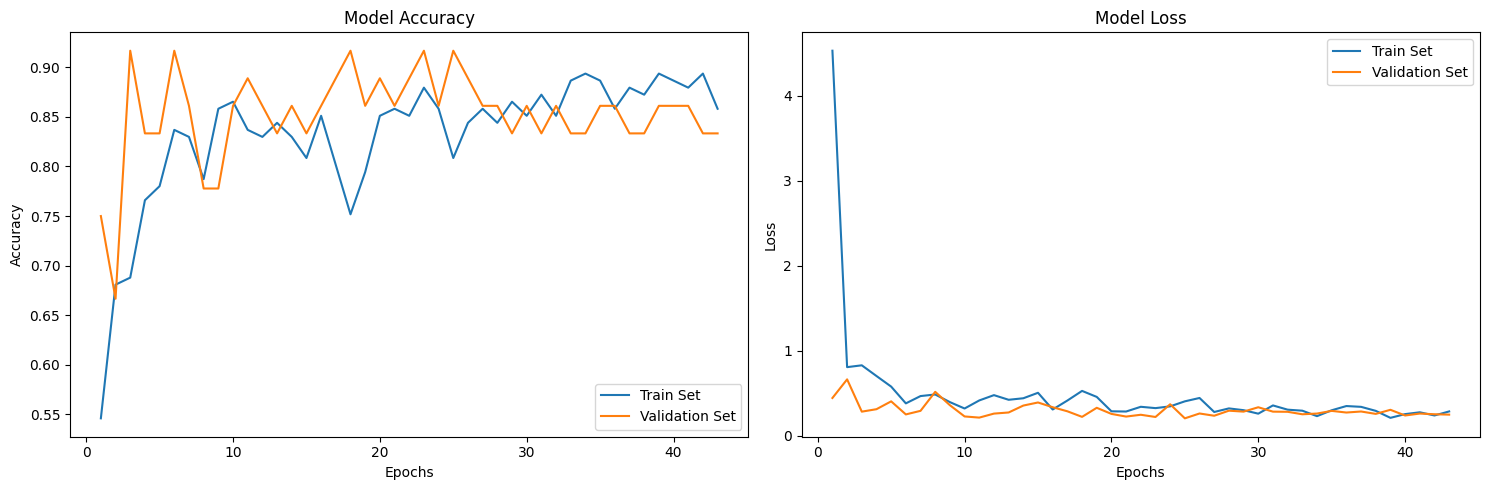

In [ ]:
# Plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']  # Validation set accuracy
loss = history.history['loss']
val_loss = history.history['val_loss']  # Validation set loss
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Validation Set')  # Add validation set accuracy
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Validation Set')  # Add validation set loss
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

predictions = resnet_model.predict(x_test)
predictions = [1 if x > 0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

f1 = f1_score(y_test, predictions)
print('F1 Score = %.2f' % f1)

confusion_mtx = confusion_matrix(y_test, predictions)
print(confusion_mtx)

3/3 [==============================] - 3s 860ms/step
Test Accuracy = 0.95
F1 Score = 0.94
[[43  2]
 [ 2 29]]


In [ ]:
model_names.append("Adding InceptionV3")
f1_scores.append(f1)
acc_scores.append(accuracy)

# 4. **Model Comparison**

In [ ]:
data = {'Model Name': model_names, 'F1 Score': f1_scores, 'Accuracy Score': acc_scores}
df = pd.DataFrame(data)
df

,Model Name,F1 Score,Accuracy Score
0,Baseline Model with MLP,0.595745,0.750000
1,Adding CNN,0.800000,0.842105
2,Adding VGG,0.785714,0.842105
3,Adding EfficientNetB2,0.866667,0.894737
4,Adding InceptionV3,0.935484,0.947368


It is evident that the model trained with `InceptionV3` achieves a high F1 score of 0.935 and accuracy score of 0.947. Comparing this with the other models listed in the table, `InceptionV3` outperforms them in terms of both F1 score and accuracy score. This indicates that `InceptionV3` is the best-performing model among the ones evaluated.

The Inception V3 model outperformed the other models, including the baseline model with MLP, the model with added CNN layers, the model with added VGG layers, and the model with added EfficientNetB2 layers. 

The superior performance of the Inception V3 model can be attributed to several factors. First, the Inception V3 architecture is specifically designed for computer vision tasks and has been shown to achieve high accuracy on image recognition tasks such as the ImageNet dataset. It incorporates symmetric and asymmetric building blocks, utilizing convolutions, pooling layers, concatenations, and dropouts, among others, to effectively capture and analyze features in images.

Another contributing factor could be the use of batch normalization, which is extensively applied throughout the Inception V3 model. Batch normalization helps stabilize and accelerate the training process, leading to improved model performance and generalization.

Additionally, the Inception V3 model utilizes the softmax function for computing the loss, which is suitable for multi-class classification tasks like image recognition. The softmax function produces probability distributions over classes, allowing the model to make more confident and accurate predictions.